In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla V100-SXM2-32GB


In [18]:
from voxel_diffusion import VoxelConfig, create_model_and_trainer, create_dataloaders

config = VoxelConfig(
    use_rgb=False,  # or False for occupancy only
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

print(config.in_channels) # Should be 1

1


In [4]:
# Create model with the given config
trainer, model = create_model_and_trainer(
    config=config,
    resolution=32,
    device=device
)

Total parameters: 120096449


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=config,
    batch_size=3
)

Finding voxel files: 198044it [01:16, 2594.68it/s]


Found 198044 files (including augmentations)


In [ ]:
# Train model
losses, test_losses = trainer.train(
    train_loader,
    test_loader,
    total_steps=70_000, # This is how many files I have: 198044 but do this to eval at the end also batch 3 200/3 = 66k we do 70k steps just in case, 4k will be repeated (- 10% for the test set)
    save_every=10_000,
    eval_every=10_000,
    save_dir='runs/experiment_1'
)

Training:   3%| | 2164/70000 [47:08<25:34:18,  1.36s/it, loss=0.2851, lr=0.00010

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
steps = list(range(0, len(test_losses) * 20_000, 20_000))
plt.plot(steps, test_losses)
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Sampling Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


(2, 1, 32, 32, 32)


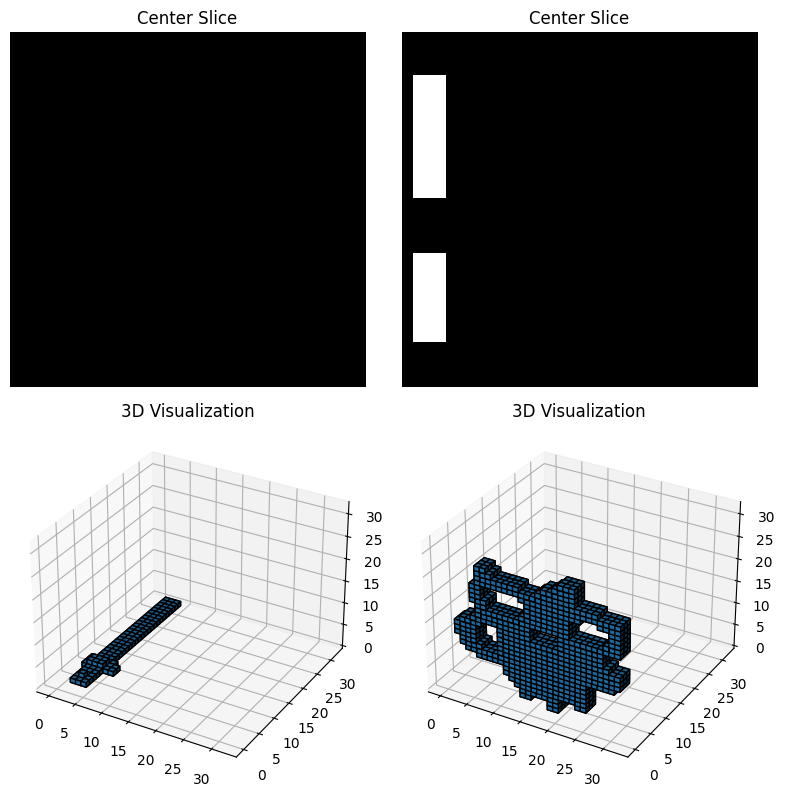

In [6]:
from inference import DiffusionInference3D
from diffusers import DDIMScheduler


diffusion_model = DiffusionModel3D(model, num_timesteps=1000)

diffusion_model.load_state_dict(torch.load("./best_model.pth"))

diffusion_model.to(device)

# noise_scheduler = DDIMScheduler.from_config(diffusion_model.noise_scheduler.config, timestep_spacing="trailing")

# inference = DiffusionInference3D(diffusion_model, noise_scheduler, device=device)
# samples = inference.sample_ddim(num_samples=2, image_size=(32, 32, 32), num_inference_steps = 200, intermediate_visualisation=True)


inference = DiffusionInference3D(diffusion_model, diffusion_model.noise_scheduler, device=device)
samples = inference.sample(num_samples=2, image_size=(32, 32, 32), show_intermediate=False)

inference.visualize_samples(samples, threshold=0.5)


In [92]:
from diffusers import UNet3DConditionModel

model = UNet3DConditionModel(
        sample_size=32,
        in_channels=1,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(64, 128, 256, 512),
        down_block_types=(
            "CrossAttnDownBlock3D",
            "CrossAttnDownBlock3D",
            "CrossAttnDownBlock3D",
            "DownBlock3D",
        ),
        up_block_types=(
            "UpBlock3D",
            "CrossAttnUpBlock3D",
            "CrossAttnUpBlock3D",
            "CrossAttnUpBlock3D",
        ),
        cross_attention_dim=512,
    )

In [93]:
from diffusion import DiffusionModel3D
from inference import DiffusionInference3D


diffusion_model = DiffusionModel3D(model, num_timesteps=1000)
diffusion_model.load_state_dict(torch.load('runs/experiment_1/models/model_step_20000.pth'))

diffusion_model.to(device)

inferencer = DiffusionInference3D(
    model=diffusion_model,
    noise_scheduler=diffusion_model.noise_scheduler,
    config=config,
    device=device
)

samples = inferencer.sample("a 3D model of a ball", num_samples=2, image_size=(32, 32, 32), show_intermediate=False)

Sampling Steps: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [03:54<00:00,  4.27it/s]


In [94]:
print(samples.shape)

torch.Size([2, 1, 32, 32, 32])


In [95]:
print(samples[1:2].min())

tensor(0.2689, device='cuda:0')


In [96]:
print(samples[1:2].max())

tensor(0.2689, device='cuda:0')


(2, 1, 32, 32, 32)


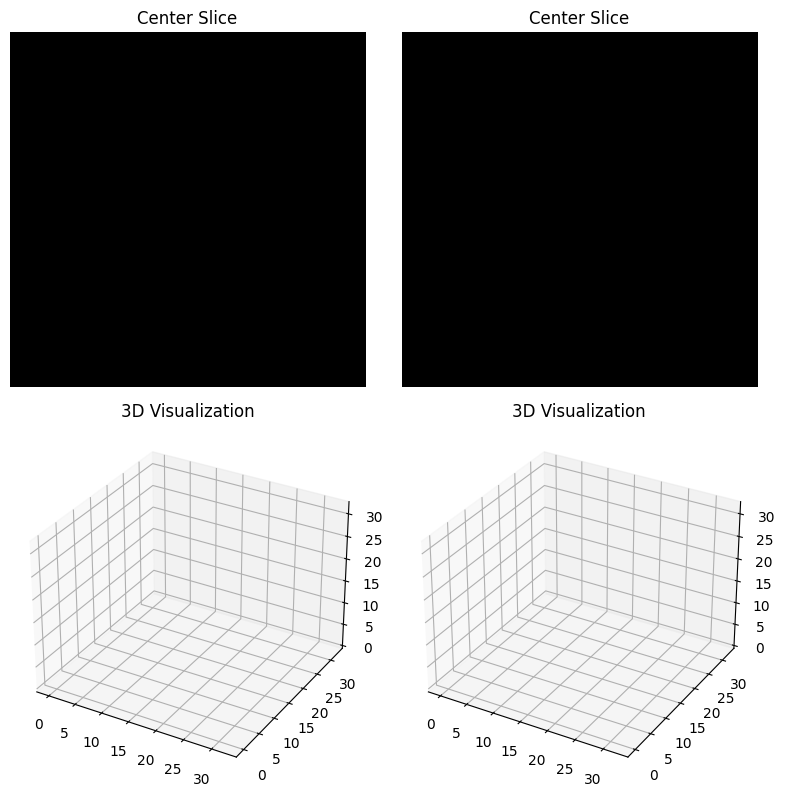

In [97]:
inferencer.visualize_samples(samples)